In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from datetime import datetime

from scipy import stats

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [467]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

## EXPLORATORY ANALYSIS

In [468]:
df.head(10)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [469]:
print(df.shape)
df.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [470]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [471]:
df.duplicated().sum()

313

In [472]:
df.columns = df.columns.str.replace(' ', '_')

df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


""" There roughly 6000 rows with this kind of data that are not int and not null
If we remove such humongous dataset, it will impact our ds training
Proposition is to conver the remaining value to an int, calculate the mean per year and replace the 
the - with the mean
"""

In [473]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

In [474]:
df.Mileage = df.Mileage.apply(lambda x: x.split(' ')[0])

In [475]:
# Convert Levy to int
cols_to_convert = ['Levy', 'Mileage', 'Cylinders']
for col in cols_to_convert:
    print('current col: ', col)
    df[col] = df[col].apply(isInt)
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype(int)


current col:  Levy
current col:  Mileage
current col:  Cylinders


In [476]:
df.Engine_volume = df.Engine_volume.str.split(' ').str[0]
df.Engine_volume = df.Engine_volume.astype(float)

In [477]:
df.describe()

,ID,Price,Levy,Prod._year,Engine_volume,Mileage,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,906.584603,2010.912824,2.307990,1.532236e+06,4.582991,6.582627
std,9.365914e+05,1.905813e+05,385.733647,5.668673,0.877805,4.840387e+07,1.199933,4.320168
min,2.074688e+07,1.000000e+00,87.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,730.000000,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,906.000000,2012.000000,2.000000,1.260000e+05,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,917.000000,2015.000000,2.500000,1.888880e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,11714.000000,2020.000000,20.000000,2.147484e+09,16.000000,16.000000


In [478]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,906,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4,Automatic,Front,04-May,Left wheel,Silver,4


In [479]:
df.groupby(['Manufacturer', 'Model', 'Prod._year'])['Levy'].value_counts().reset_index()

,Manufacturer,Model,Prod._year,Levy,count
0,ACURA,MDX,2011,1234,1
1,ACURA,MDX,2012,1113,2
2,ACURA,RDX,2014,1053,2
3,ACURA,RDX,2015,1273,1
4,ACURA,TL,2010,1399,1
...,...,...,...,...,...
5345,VOLVO,XC90 3.2 AWD,2012,975,1
5346,ZAZ,969 968m,1989,906,1
5347,ZAZ,969 luaz,1990,906,1
5348,სხვა,GONOW,2005,906,1


#### ::: From observation: Drop some features that serve no purpose

In [480]:
# Drop features that offer no trend or of no significant importance
# Not dropping engine vol or turbo_engine because this is a used car and it most business settings, that affects its resale value
# Drop the ID col and Doors cols ::: ID cols offers no value or trend, Doors col  is populated with the wrong data
# Levy does not show a particular trend that the model can work with
cols_to_drop = ['ID', 'Levy', 'Doors', 'Wheel', 'Drive_wheels', 'Color']
df = df.drop(cols_to_drop, axis=1)
df

,Price,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags
0,13328,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6,Automatic,12
1,16621,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6,Tiptronic,8
2,8467,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4,Variator,2
3,3607,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4,Automatic,0
4,11726,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4,Automatic,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0,300000,4,Manual,5
19233,15681,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600,4,Tiptronic,8
19234,26108,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2.0,116365,4,Automatic,4
19235,5331,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2.0,51258,4,Automatic,4


## ::: Visualization and Analysis

In [481]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['Price', 'Prod._year', 'Engine_volume', 'Mileage', 'Cylinders',
       'Airbags'],
      dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather_interior', 'Fuel_type',
       'Gear_box_type'],
      dtype='object')


#### Let's handle outliers

#### Before using IQR to remove analysis

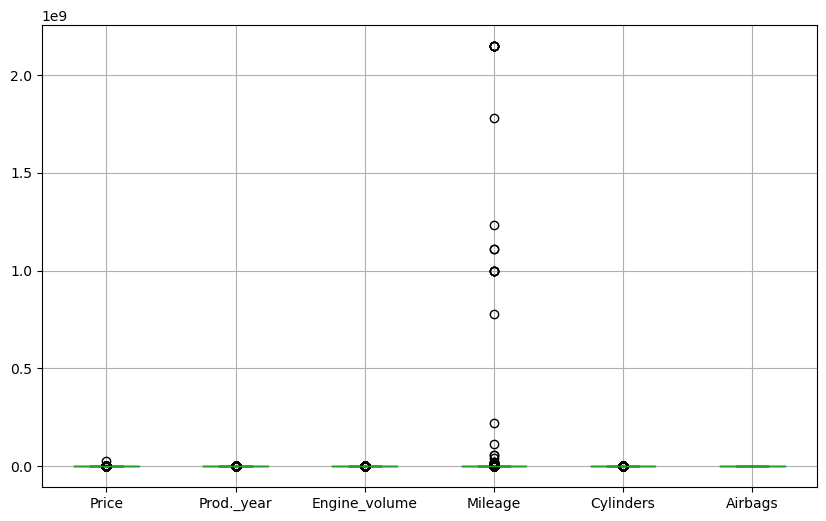

In [482]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols);

In [ ]:
df.hist(bins = 28, figsize=(15, 10), color ='olive');

In [483]:
# def cap_or_floor_outliers(col_name, df):
#     lower_cap = df[col_name].quantile(0.25)
#     upper_cap = df[col_name].quantile(0.75)
    
#     print(f'upper_limit: ', {upper_cap})
#     print(f'lower_limit: ', {lower_cap})
#     df[col_name] = np.where(df[col_name] < lower_cap, lower_cap, df[col_name])
#     df[col_name] = np.where(df[col_name] > upper_cap, upper_cap, df[col_name])

#     return df

In [484]:
def get_and_remove_outliers(col, df):
    # Define the thresholds (10th and 90th percentiles in this case)
    lower_limit, upper_limit = df[col].quantile([0.15, 0.85])
    
    print(f'Upper limit: {upper_limit}')
    print(f'Lower limit: {lower_limit}')
    
    # Filter the DataFrame to remove outliers
    no_outliers = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]

    return no_outliers

In [485]:
df = get_and_remove_outliers(df=df, col='Mileage')

Upper limit: 230000.0
Lower limit: 42782.8


In [486]:
df = get_and_remove_outliers(df=df, col='Price')

Upper limit: 31361.0
Lower limit: 2297.3999999999965


#### After using IQR to remove analysis

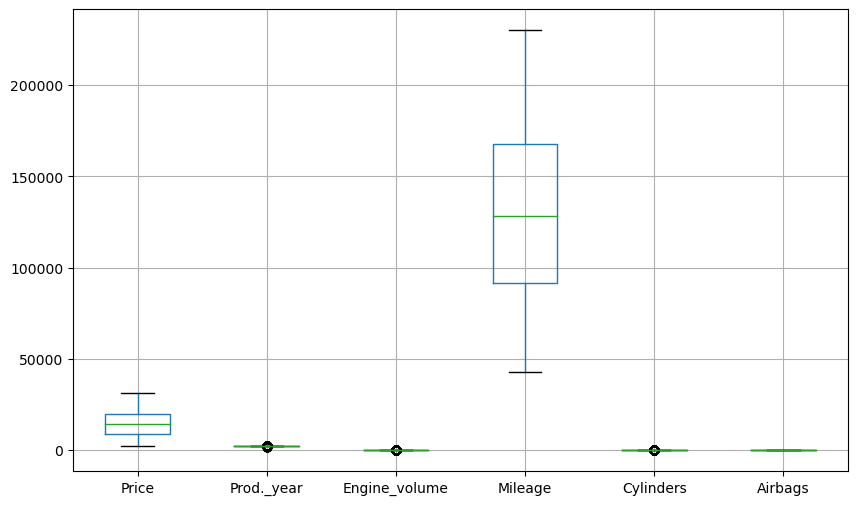

In [487]:
#Create a boc plot to visualize outliers in the numerical cols
numerical_data = df.select_dtypes(exclude=object)
numerical_data
cols = [col for col in numerical_data]
numerical_data.boxplot(figsize=(10,6), column=cols);

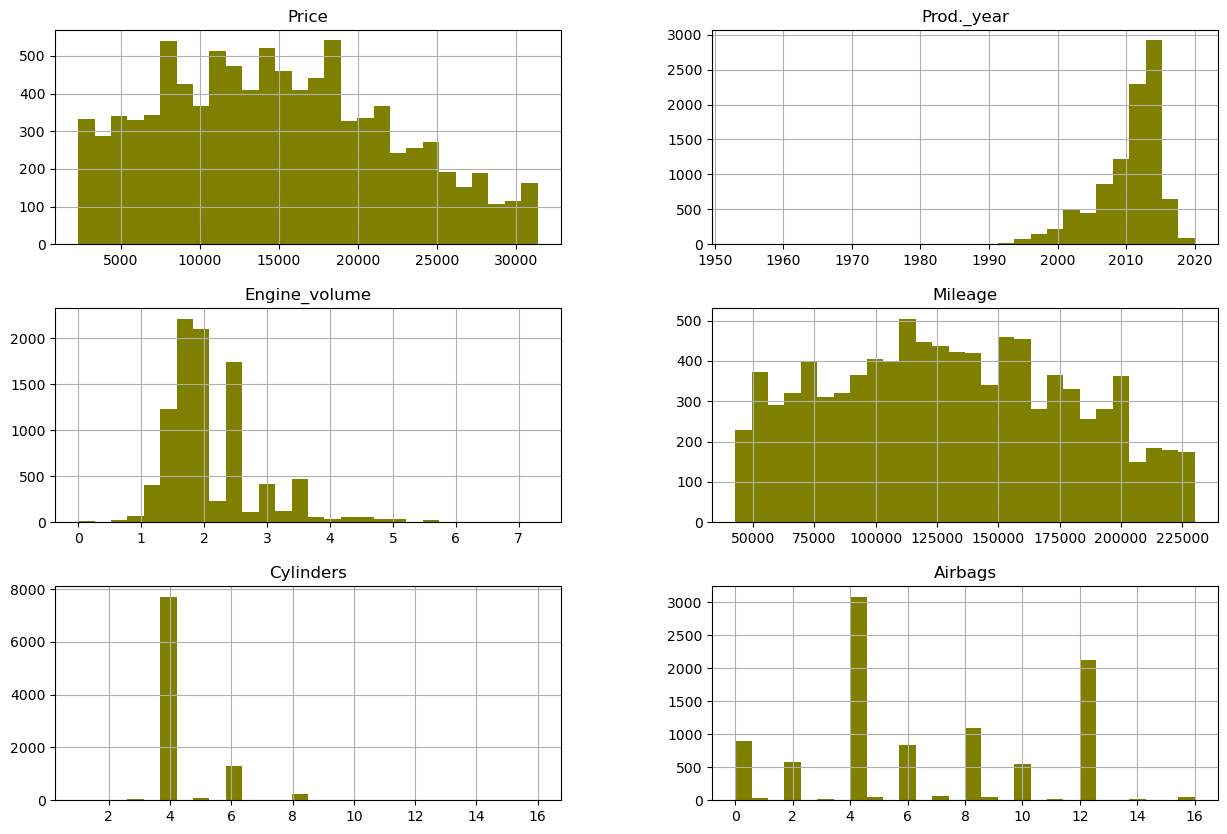

In [488]:
df.hist(bins = 28, figsize=(15, 10), color ='olive');

In [489]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9451 entries, 0 to 19235
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             9451 non-null   int64  
 1   Manufacturer      9451 non-null   object 
 2   Model             9451 non-null   object 
 3   Prod._year        9451 non-null   int64  
 4   Category          9451 non-null   object 
 5   Leather_interior  9451 non-null   object 
 6   Fuel_type         9451 non-null   object 
 7   Engine_volume     9451 non-null   float64
 8   Mileage           9451 non-null   int64  
 9   Cylinders         9451 non-null   int64  
 10  Gear_box_type     9451 non-null   object 
 11  Airbags           9451 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 959.9+ KB


#### Categorical features visualization for understanding

In [ ]:
grouped_df = df.groupby(['Manufacturer', 'Model']).sum().unstack()
grouped_df.plot(kind='bar', stacked=True)

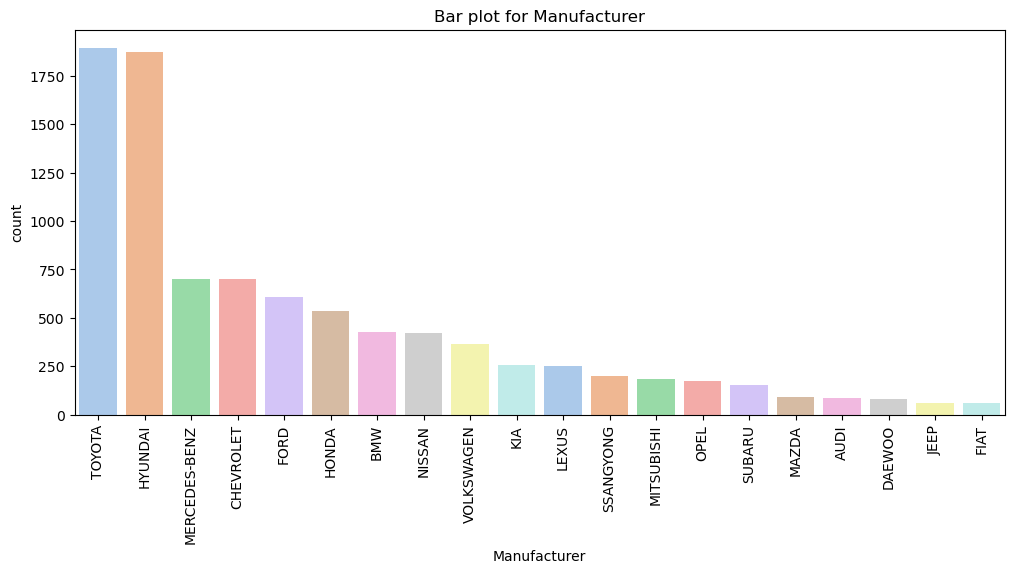

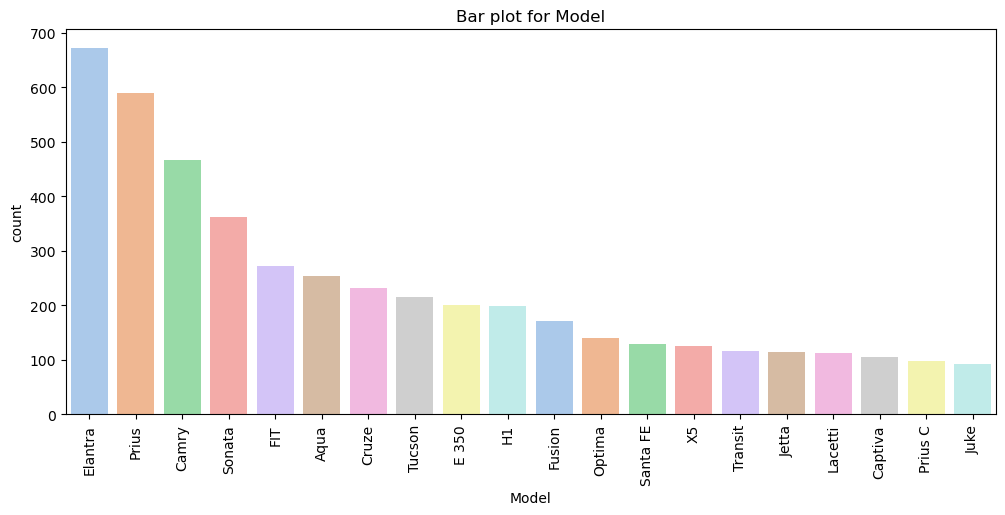

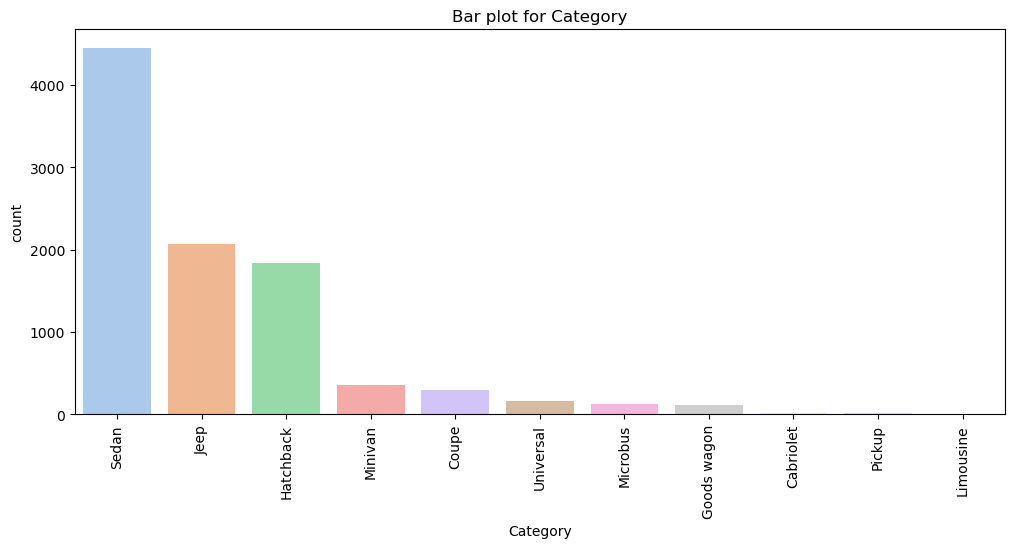

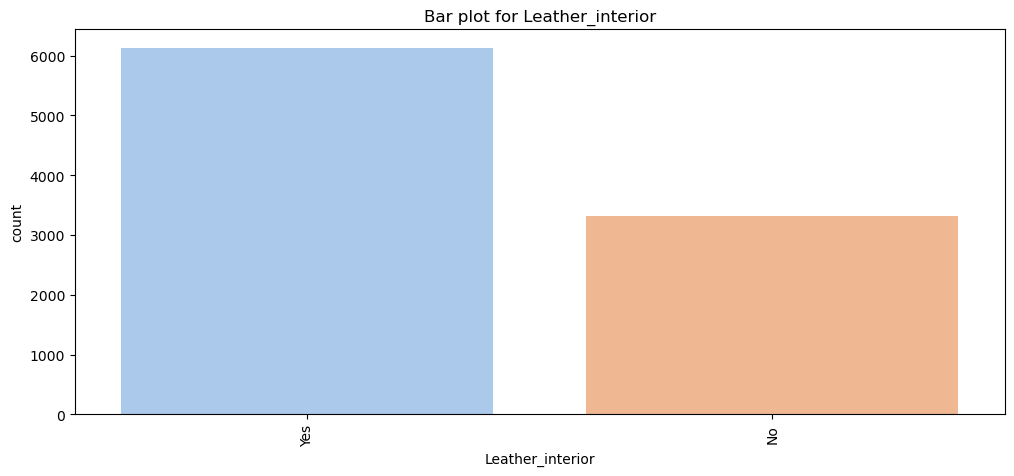

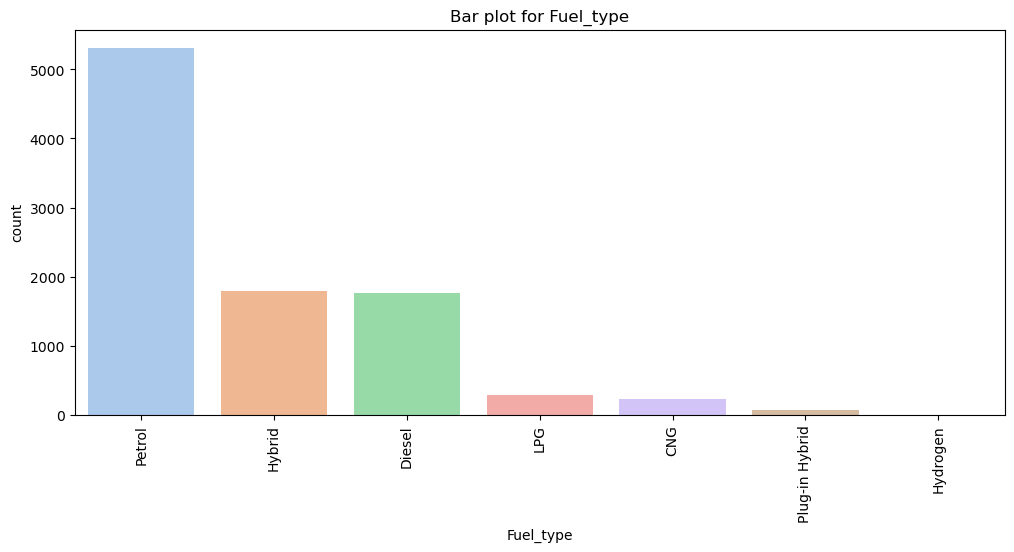

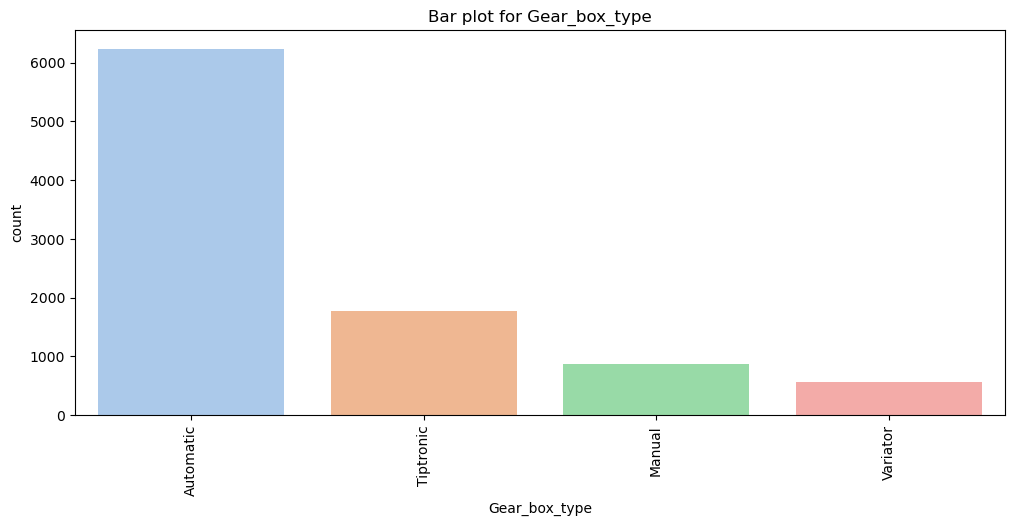

In [492]:
# create a function to draw a barplot for all categorical features
def plot_cat_barplot():
    for cols in categorical_cols:
        plt.figure(figsize=(12,5))
        value = df[cols].value_counts(ascending=False).reset_index()[:20]
        sns.barplot(x=cols, y='count', data=value, hue=cols, palette='pastel')
        plt.xticks(rotation=90)
        plt.title(f'Bar plot for {cols}')
    
plot_cat_barplot()

Analysis if there is a relationship between some categorical features and prices e.g Leather interior

Text(0.5, 1.0, 'Average Price by Leather Interior')

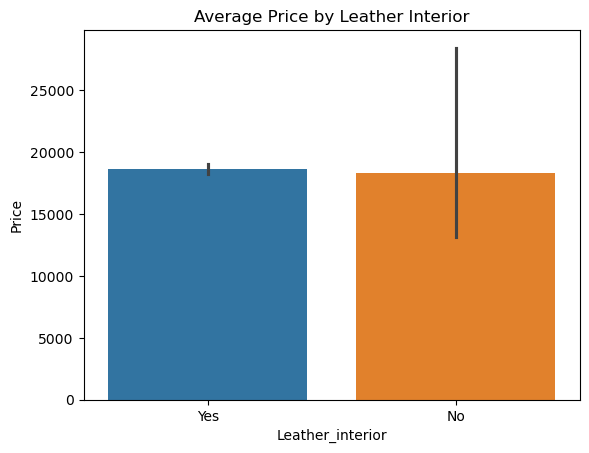

In [856]:
sns.barplot(x='Leather_interior', y='Price', data=df, estimator=np.mean, hue='Leather_interior')
plt.title('Average Price by Leather Interior')

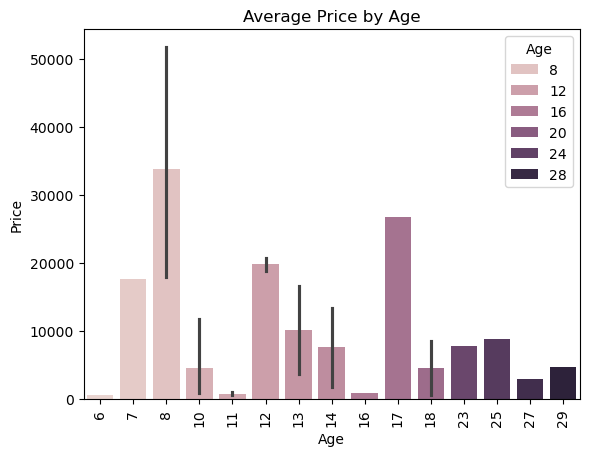

In [857]:

sns.barplot(x='Age', y='Price', data=df.iloc[:25], estimator=np.mean, hue='Age')
plt.title('Average Price by Age')
plt.xticks(rotation=90);

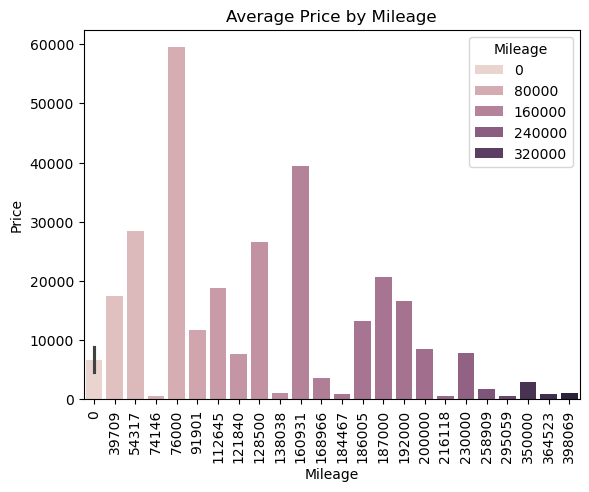

In [858]:

sns.barplot(x='Mileage', y='Price', data=df.iloc[:25], estimator=np.mean, hue='Mileage')
plt.title('Average Price by Mileage')
plt.xticks(rotation=90);

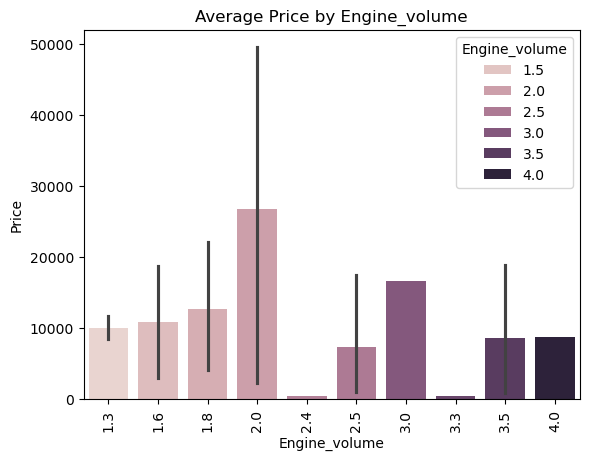

In [859]:

sns.barplot(x='Engine_volume', y='Price', data=df.iloc[:25], estimator=np.mean, hue='Engine_volume')
plt.title('Average Price by Engine_volume')
plt.xticks(rotation=90);

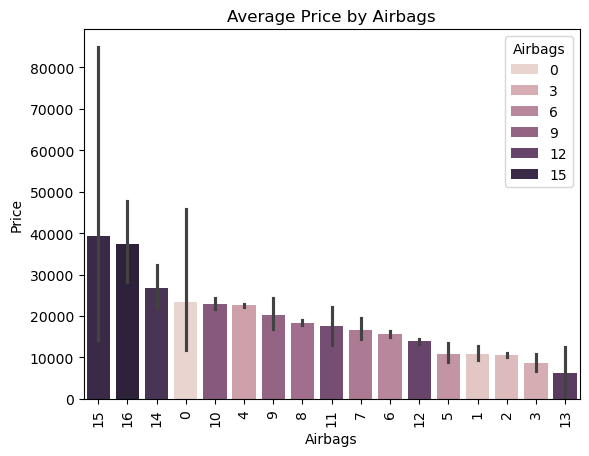

In [860]:
mean_price_by_airbags = df.groupby('Airbags')['Price'].mean().reset_index()
mean_price_by_airbags_sorted = mean_price_by_airbags.sort_values(by='Price', ascending=False)


sns.barplot(x='Airbags', y='Price', data=df, estimator=np.mean, hue='Airbags',order=mean_price_by_airbags_sorted['Airbags'])
plt.title('Average Price by Airbags')
plt.xticks(rotation=90);

Let's create a corr heatmap to see features that are closely related 
Features with a 0.8 corr will dropped in place of that which does not 
have an outlier

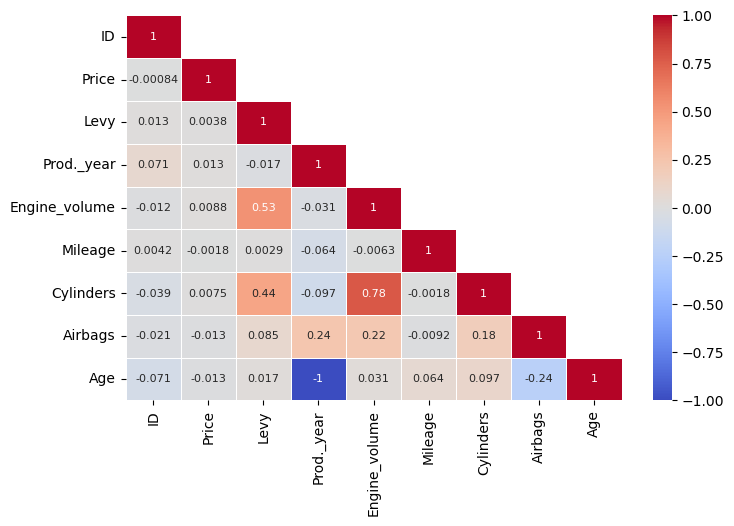

In [874]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition
plt.figure(figsize=(8,5))
mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={'size': 8});

Let's visualize the relationship between two numerical variables. It is especially useful for identifying correlations, trends, clusters, and potential outliers in data

In [865]:
df.groupby(['Manufacturer', 'Model'])['Price'].value_counts()

Manufacturer  Model         Price
ACURA         MDX           4861     2
                            11760    1
              RDX           282      1
                            4391     1
                            39201    1
                                    ..
VOLVO         XC90 3.2 AWD  21326    1
ZAZ           969 968m      2000     1
              969 luaz      5645     1
სხვა          GONOW         9408     1
              IVECO DAYLY   25089    1
Name: count, Length: 10645, dtype: int64

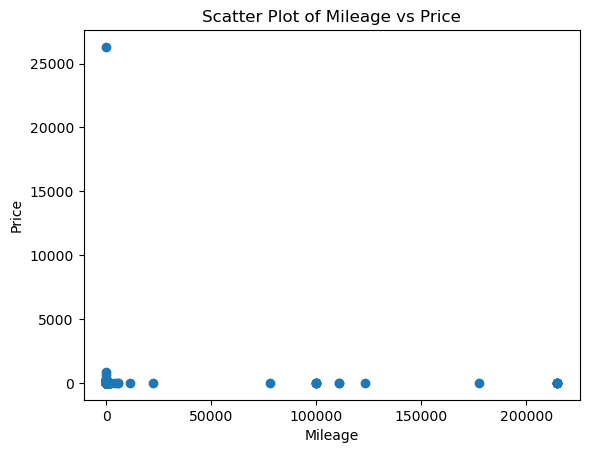

In [776]:
plt.scatter(x=df['Mileage']/10000, y=df['Price']/1000)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Scatter Plot of Mileage vs Price')
plt.show()

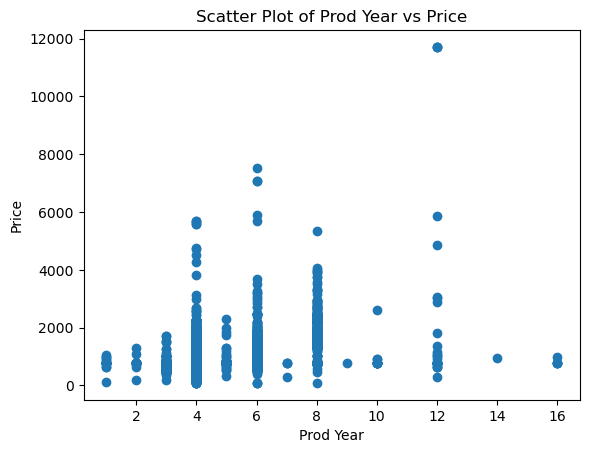

In [777]:
plt.scatter(x=df['Cylinders'], y=df['Levy'])
plt.xlabel('Prod Year')
plt.ylabel('Price')
plt.title('Scatter Plot of Prod Year vs Price')
plt.show()

,Price,Levy,Manufacturer,Model,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags,Age
0,13328,1399,LEXUS,RX 450,Yes,Hybrid,3.5,186005,6,Automatic,12,14
1,16621,1018,CHEVROLET,Equinox,No,Petrol,3.0,192000,6,Tiptronic,8,13
2,8467,781,HONDA,FIT,No,Petrol,1.3,200000,4,Variator,2,18
3,3607,862,FORD,Escape,Yes,Hybrid,2.5,168966,4,Automatic,0,13
4,11726,446,HONDA,FIT,Yes,Petrol,1.3,91901,4,Automatic,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,781,MERCEDES-BENZ,CLK 200,Yes,CNG,2.0,300000,4,Manual,5,25
19233,15681,831,HYUNDAI,Sonata,Yes,Petrol,2.4,161600,4,Tiptronic,8,13
19234,26108,836,HYUNDAI,Tucson,Yes,Diesel,2.0,116365,4,Automatic,4,14
19235,5331,1288,CHEVROLET,Captiva,Yes,Diesel,2.0,51258,4,Automatic,4,17


upper_limit:  {265210.0}
lower_limit:  {25061.400000000005}


In [782]:
df.Mileage.describe()

count     15386.000000
mean     130168.060640
std       59643.371036
min       25077.000000
25%       82392.000000
50%      126000.000000
75%      173913.000000
max      265000.000000
Name: Mileage, dtype: float64

In [783]:
df.Levy.describe()

count    15386.000000
mean       855.344274
std        382.756513
min         87.000000
25%        698.250000
50%        781.000000
75%        911.000000
max      11714.000000
Name: Levy, dtype: float64

upper_limit:  {1266.0}
lower_limit:  {552.0}


upper_limit:  {39582.500000000015}
lower_limit:  {941.0}


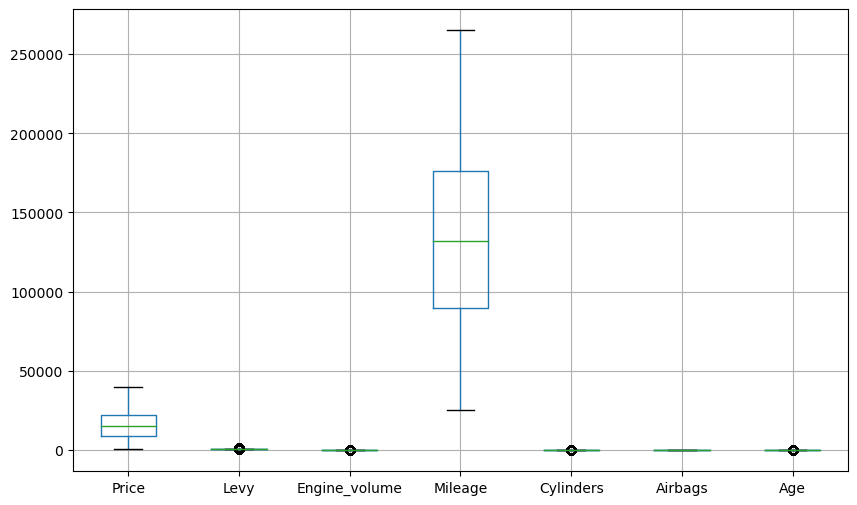

In [787]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9807 entries, 1 to 19234
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             9807 non-null   int64  
 1   Levy              9807 non-null   int64  
 2   Manufacturer      9807 non-null   object 
 3   Model             9807 non-null   object 
 4   Leather_interior  9807 non-null   object 
 5   Fuel_type         9807 non-null   object 
 6   Engine_volume     9807 non-null   float64
 7   Mileage           9807 non-null   int64  
 8   Cylinders         9807 non-null   int64  
 9   Gear_box_type     9807 non-null   object 
 10  Airbags           9807 non-null   int64  
 11  Age               9807 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 996.0+ KB


In [788]:
models = df.groupby('Manufacturer')['Model'].unique().apply(list)
models_list = models['TOYOTA']
models_list

['Prius',
 'Camry',
 'Aqua',
 'VOXY',
 'Vitz',
 'Yaris',
 'RAV 4',
 'Vitz funkargo',
 'RAV 4 XLE Sport',
 'Avalon LIMITED',
 'Ist',
 'Corolla',
 'RAV 4 Le',
 'Camry SE',
 'Prius C',
 'Highlander',
 'Corolla IM',
 'Corolla verso',
 'Ipsum',
 'Corolla 04',
 'Passo',
 'Prius V',
 'CHR',
 'Ist 1.5',
 'Harrier',
 'Camry se',
 'Corolla LE',
 'Camry S',
 'Sienna',
 'Ipsum S',
 'Prius plugin',
 'Camry Se',
 'Verso',
 'Alphard',
 'ISIS',
 'Venza',
 'Corolla S',
 'Tacoma',
 'Land Cruiser Prado',
 'Auris',
 'Altezza',
 'Camry SPORT',
 'Hilux',
 'Camry sport',
 'Caldina',
 'Hilux Surf',
 'Prius C Navigation',
 'Camry XLE',
 'Highlander sport',
 'Aqua L paketi',
 'Avensis',
 'Prius s',
 'Will Vs',
 'Prius BLUG-IN',
 'Estima',
 'Camry sporti',
 'Camry LE',
 'Avalon limited',
 'Wish',
 'Vitz RS',
 'Fun Cargo',
 'Corolla Im',
 'Prius ფლაგინი',
 'Prius 1.5I',
 'Mark X',
 'Yaris iA',
 'Camry sport se',
 'Highlander LIMITED',
 'Camry XV50',
 'Prius ჰიბრიდი',
 'Aqua HIBRID',
 'Celica',
 'RAV 4 SPORT',
 'P

In [789]:
man_counts = df['Manufacturer'].value_counts()

# Filter out Models that appear less than 10 times
df = df[df['Manufacturer'].isin(man_counts[man_counts >= 2].index)]
df

,Price,Levy,Manufacturer,Model,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags,Age
1,16621,1018,CHEVROLET,Equinox,No,Petrol,3.0,192000,6,Tiptronic,8,13
2,8467,781,HONDA,FIT,No,Petrol,1.3,200000,4,Variator,2,18
3,3607,862,FORD,Escape,Yes,Hybrid,2.5,168966,4,Automatic,0,13
5,39493,891,HYUNDAI,Santa FE,Yes,Diesel,2.0,160931,4,Automatic,4,8
6,1803,761,TOYOTA,Prius,Yes,Hybrid,1.8,258909,4,Automatic,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,781,NISSAN,Skyline,Yes,Petrol,3.0,220000,6,Tiptronic,0,21
19227,29793,1053,MERCEDES-BENZ,E 350,Yes,Diesel,3.5,219030,6,Automatic,12,10
19231,5802,1055,MERCEDES-BENZ,E 350,Yes,Diesel,3.5,107800,6,Automatic,12,11
19233,15681,831,HYUNDAI,Sonata,Yes,Petrol,2.4,161600,4,Tiptronic,8,13


In [790]:
model_counts = df['Model'].value_counts()

# Filter out Models that appear less than 10 times
df = df[df['Model'].isin(model_counts[model_counts >= 5].index)]
df

,Price,Levy,Manufacturer,Model,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Airbags,Age
1,16621,1018,CHEVROLET,Equinox,No,Petrol,3.0,192000,6,Tiptronic,8,13
2,8467,781,HONDA,FIT,No,Petrol,1.3,200000,4,Variator,2,18
3,3607,862,FORD,Escape,Yes,Hybrid,2.5,168966,4,Automatic,0,13
5,39493,891,HYUNDAI,Santa FE,Yes,Diesel,2.0,160931,4,Automatic,4,8
6,1803,761,TOYOTA,Prius,Yes,Hybrid,1.8,258909,4,Automatic,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,781,NISSAN,Skyline,Yes,Petrol,3.0,220000,6,Tiptronic,0,21
19227,29793,1053,MERCEDES-BENZ,E 350,Yes,Diesel,3.5,219030,6,Automatic,12,10
19231,5802,1055,MERCEDES-BENZ,E 350,Yes,Diesel,3.5,107800,6,Automatic,12,11
19233,15681,831,HYUNDAI,Sonata,Yes,Petrol,2.4,161600,4,Tiptronic,8,13


In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8542 entries, 1 to 19234
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             8542 non-null   int64  
 1   Levy              8542 non-null   int64  
 2   Manufacturer      8542 non-null   object 
 3   Model             8542 non-null   object 
 4   Leather_interior  8542 non-null   object 
 5   Fuel_type         8542 non-null   object 
 6   Engine_volume     8542 non-null   float64
 7   Mileage           8542 non-null   int64  
 8   Cylinders         8542 non-null   int64  
 9   Gear_box_type     8542 non-null   object 
 10  Airbags           8542 non-null   int64  
 11  Age               8542 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 867.5+ KB


In [792]:
# for col in categorical_cols:
#     plt.figure(figsize=(20,10))
#     sns.countplot(data=df, x=col, hue=col, palette='pastel')
#     plt.title(f'Count plot of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.xticks(rotation=45);

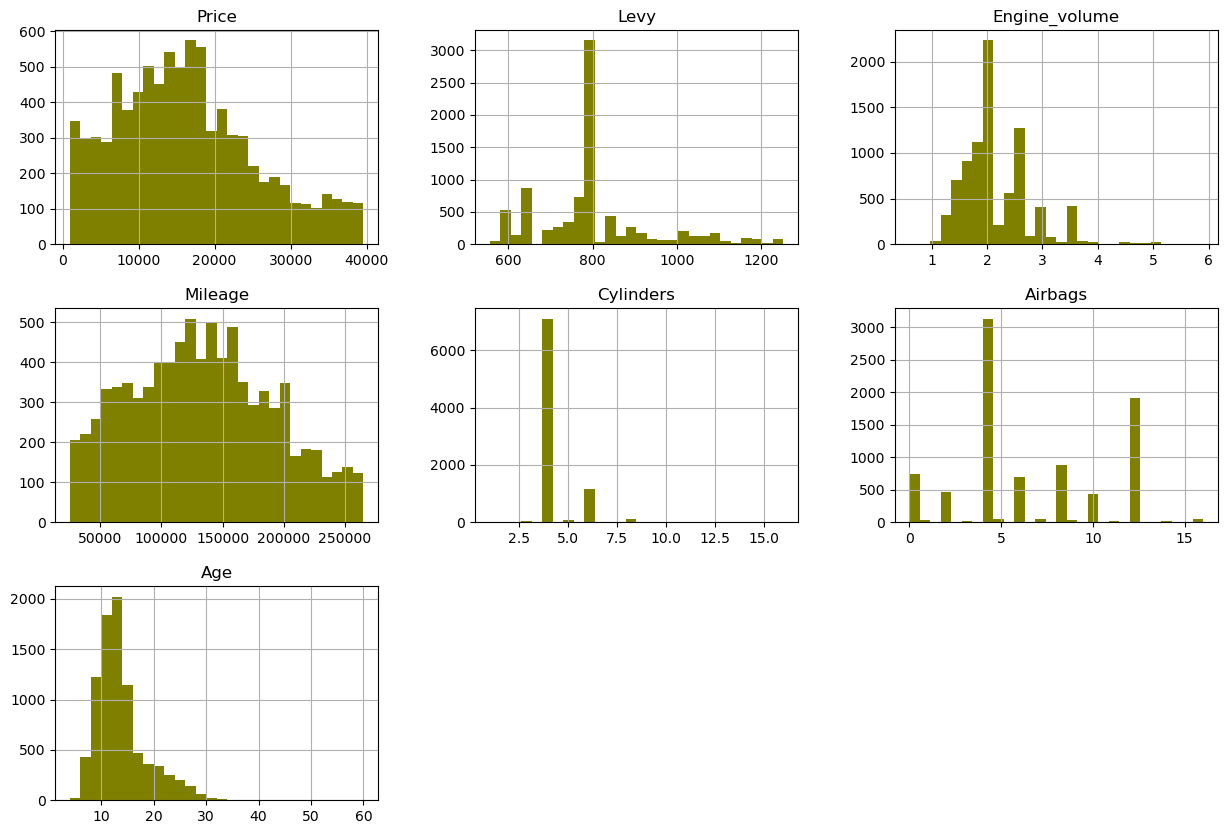

In [794]:
df.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Leather_interior',
       'Fuel_type', 'Engine_volume', 'Mileage', 'Cylinders', 'Gear_box_type',
       'Airbags', 'Age'],
      dtype='object')

In [795]:
"""STANDARDIZATION"""
scaler = StandardScaler()

scaled_data_mileage = scaler.fit_transform(df[['Mileage']])

df.loc[:,'Mileage'] = scaled_data_mileage

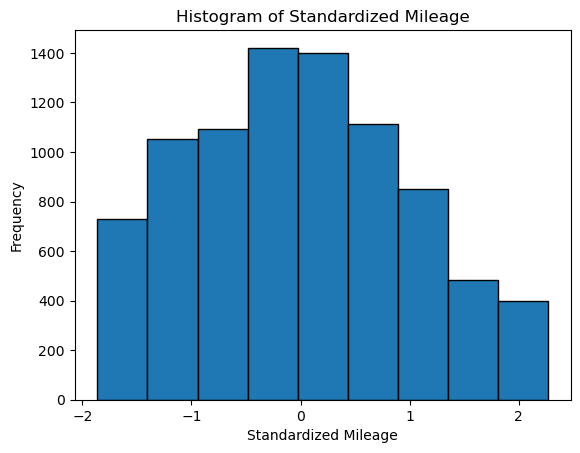

In [796]:
# plot a histogram to showcase the standardized values
plt.hist(df.Mileage, bins=9, edgecolor='black')
plt.xlabel('Standardized Mileage')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Mileage');

In [797]:
cleaned_df = df.copy()

In [798]:
# Dsplay the Manufacturer, Model against the Category
cat_df = cleaned_df.copy()
cat_df['group'] = cat_df['Manufacturer']
pivot_table = pd.pivot_table(cat_df, columns='Fuel_type', values='Manufacturer', index=['group'], aggfunc='count', fill_value=0)
pivot_table['row_sum'] = pivot_table.sum(axis=1)
pivot_table = pivot_table[['row_sum'] + [col for col in pivot_table.columns if col != 'row_sum']]

pivot_table.sort_values(ascending=False, by='row_sum').head()

Fuel_type,row_sum,CNG,Diesel,Hybrid,LPG,Petrol,Plug-in Hybrid
group,,,,,,,
HYUNDAI,2149,0,891,57,219,982,0
TOYOTA,1567,9,8,885,18,640,7
MERCEDES-BENZ,634,54,251,0,26,303,0
CHEVROLET,579,0,214,0,14,334,17
FORD,462,2,128,105,1,211,15


In [799]:
dummies_manu = pd.get_dummies(cleaned_df['Manufacturer'], drop_first=True, dtype=int)
dummies_model = pd.get_dummies(cleaned_df['Model'], drop_first=True, dtype=int)
dummies_fuel_type = pd.get_dummies(cleaned_df['Fuel_type'], drop_first=True, dtype=int)
dummies_gear = pd.get_dummies(cleaned_df['Gear_box_type'], drop_first=True, dtype=int)
dummies_leather_int = pd.get_dummies(cleaned_df['Leather_interior'], drop_first=True, dtype=int)

In [800]:
cols_to_encode = ['Manufacturer', 'Model', 'Fuel_type', 'Gear_box_type', 'Leather_interior']
cleaned_df = pd.concat([cleaned_df.drop(columns=cols_to_encode), dummies_manu, dummies_fuel_type, dummies_model, dummies_gear, dummies_leather_int], axis=1)

In [801]:
cleaned_df

,Price,Levy,Engine_volume,Mileage,Cylinders,Airbags,Age,BMW,BUICK,CHEVROLET,...,VOLKSWAGEN,Diesel,Hybrid,LPG,Petrol,Plug-in Hybrid,Manual,Tiptronic,Variator,Yes
1,16621,1018,3.0,1.011727,6,8,13,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,8467,781,1.3,1.149673,4,2,18,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,3607,862,2.5,0.614548,4,0,13,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,39493,891,2.0,0.476000,4,4,8,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,1803,761,1.8,2.165450,4,12,14,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19226,7840,781,3.0,1.494536,6,0,21,0,0,0,...,0,0,0,0,1,0,0,1,0,1
19227,29793,1053,3.5,1.477810,6,12,10,0,0,0,...,0,1,0,0,0,0,0,0,0,1
19231,5802,1055,3.5,-0.440147,6,12,11,0,0,0,...,0,1,0,0,0,0,0,0,0,1
19233,15681,831,2.4,0.487535,4,8,13,0,0,0,...,0,0,0,0,1,0,0,1,0,1


In [802]:
"""TRAIN TEST SPLIT"""

'TRAIN TEST SPLIT'

In [803]:
X = cleaned_df.drop('Price', axis=1)
y = cleaned_df.Price

In [804]:
# X_scaled = scaler.fit_transform(X)

In [805]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [806]:
lr_model = LinearRegression(n_jobs=10)
lr_model.fit(X_train, y_train)

LinearRegression(n_jobs=10)

In [807]:
lr_model.score(X_test, y_test)

0.37830637692879165

In [808]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [809]:
def get_best_model(X,y):
    model_params = {
        'random_forest_reg': {
            'model': RandomForestRegressor(),
            'params': {
                'max_depth': [10, 20],
                'n_estimators': [100, 150],
            }
        },
        'xgb_regressor': {
            'model': XGBRegressor(objective='reg:squarederror', enable_categorical=True),
            'params': {
                'n_estimators': [300]
            }
        }
    }
    scores = []
    for model_name, mp in model_params.items():
        gs = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model_name': model_name,
            'best_params': gs.best_params_,
            'best_score': gs.best_score_
        })
    best_model = pd.DataFrame(scores, columns=['model_name', 'best_params', 'best_score'])
    return best_model

In [810]:
get_best_model(X_train, y_train)

,model_name,best_params,best_score
0,random_forest_reg,"{'max_depth': 20, 'n_estimators': 150}",0.735376
1,xgb_regressor,{'n_estimators': 300},0.718020


In [811]:
def train_test_cross_validate(model, X_train, y_train, X_test, y_test, cv):
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    # Train pred
    y_train_pred = model.predict(X_train)
    rmse_train = mean_absolute_error(y_train, y_train_pred)

    # Test Pred
    y_test_pred = model.predict(X_test)
    rmse_test = mean_absolute_error(y_test, y_test_pred)

    # Perform 5-fold cross-validation
    rmse_cv = -cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

    rmse_cv_mean = np.mean(rmse_cv)

    # Display results
    print(f'Model Score: {model_score:.4f}')
    print(f"Training RMSE: {rmse_train:.4f}")
    print()
    print(f"Initial Test RMSE: {rmse_test:.4f}")
    print()
    print(f"Average Cross-Validation RMSE: {rmse_cv_mean:.4f}")
    print()
    print(f"Cross-Validation Scores: {rmse_cv}\n")
    print()

In [812]:
additional_params = {
    'X_train' : X_train, 
    'y_train' : y_train, 
    'X_test' : X_test, 
    'y_test': y_test, 
    'cv':10}


models = {
    'Xgboost': XGBRegressor(n_estimators=100),
    'Random Forest': RandomForestRegressor(max_depth=10, n_estimators=200),
}

for model_name, model in models.items():
    print(f'{model_name} Regression Model: ')
    print()

    trained_model = train_test_cross_validate(model, **additional_params)

    print(trained_model)

Xgboost Regression Model: 

Model Score: 0.7476
Training RMSE: 2076.9505

Initial Test RMSE: 3313.8230

Average Cross-Validation RMSE: 4655.3064

Cross-Validation Scores: [4587.93093261 4512.28485116 5112.78204756 4512.2215641  4736.82168404
 4725.29837327 4265.74351091 5160.66240545 4606.92722885 4332.39166878]


None
Random Forest Regression Model: 

Model Score: 0.7156
Training RMSE: 2911.8723

Initial Test RMSE: 3652.4327

Average Cross-Validation RMSE: 4923.2154

Cross-Validation Scores: [4736.97724061 4698.6888733  5278.777183   4975.89505236 4833.26833062
 4996.99314211 4522.41147217 5472.38186581 5133.30302934 4583.45740876]


None
